## Initial Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils import resample
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
import sklearn.metrics as m
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

## Data Pre-Processing

In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/'

In [ ]:
df = pd.read_csv(base_path + 'datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['img_path'] = base_path + 'datasets/train/images/' + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [ ]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_count = 1200
df_balanced = pd.DataFrame(columns=df.columns)

for label in classes:
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
len(df)

8400

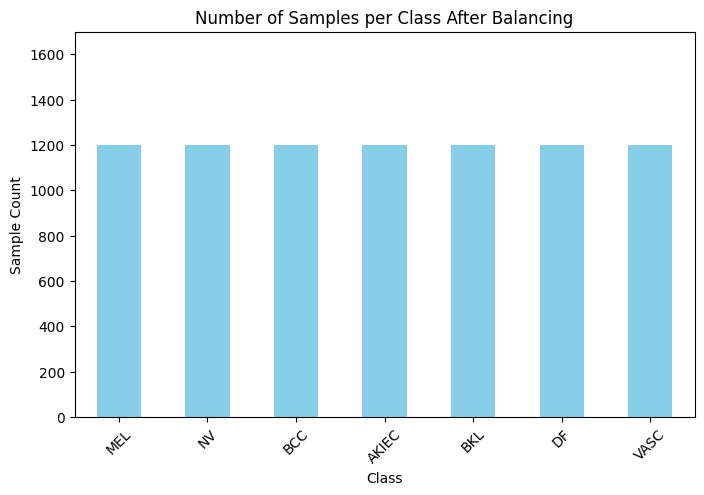

In [ ]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [ ]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training:
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

df_train = create_dataset(df, training=True)

In [ ]:
df_validate = pd.read_csv(base_path + 'datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = base_path + 'datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv(base_path + 'datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = base_path + 'datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [ ]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [ ]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Model Building and Training


In [ ]:
def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    # Multi-head Self Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=dropout)(x, x)
    x = layers.Add()([x, inputs])

    # Feed-forward network
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(ff_dim, activation='relu')(y)
    y = layers.Dense(inputs.shape[-1])(y)
    return layers.Add()([y, x])

In [ ]:
def build_vit_model(patch_size, num_patches, num_classes):
    transformer_layers = 6
    num_heads = 4
    ff_dim = 128
    inputs = layers.Input(shape=(224, 224, 3))

    # Create patches
    patches = layers.Conv2D(filters=64, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((num_patches, -1))(patches)

    # Add positional embedding
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=patches.shape[-1])
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded = patches + position_embedding(positions)

    # Transformer blocks
    for _ in range(transformer_layers):
        encoded = transformer_encoder(encoded, num_heads, ff_dim)

    # Classification head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded)
    representation = layers.GlobalAveragePooling1D()(representation)
    outputs = layers.Dense(num_classes, activation='softmax')(representation)

    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = build_vit_model(patch_size=16, num_patches=(224 // 16) ** 2, num_classes=7)
model.compile(optimizer=Adam(learning_rate=3.7e-4),loss='categorical_crossentropy',metrics=['accuracy'])

total_params = model.count_params()
print(f"Total Parameters: {total_params:,}")

Total Parameters: 548,999


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
start_time = time.time()
hist = model.fit(df_train,epochs=30,validation_data=df_validate,callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model ViT Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 760s 632ms/step - accuracy: 0.2119 - loss: 1.8974 - val_accuracy: 0.5389 - val_loss: 1.1647 - learning_rate: 3.7000e-04
Epoch 2/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.4433 - loss: 1.3905 - val_accuracy: 0.6062 - val_loss: 0.9934 - learning_rate: 3.7000e-04
Epoch 3/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - accuracy: 0.4803 - loss: 1.2848 - val_accuracy: 0.5751 - val_loss: 1.0683 - learning_rate: 3.7000e-04
Epoch 4/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.5312 - loss: 1.1871 - val_accuracy: 0.6528 - val_loss: 1.0009 - learning_rate: 3.7000e-04
Epoch 5/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.5475 - loss: 1.1395 - val_accuracy: 0.5285 - val_loss: 1.2593 - learning_rate: 3.7000e-04
Epoch 6/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.5774 - loss: 1.0746 - val_accuracy: 0.5596 - val_loss: 1.1759 - learning_rate: 3.7000e-04
Epoch 7/30
1050/1050 ━━━━━━━━━━━━━━━━━

## Model Evaluation

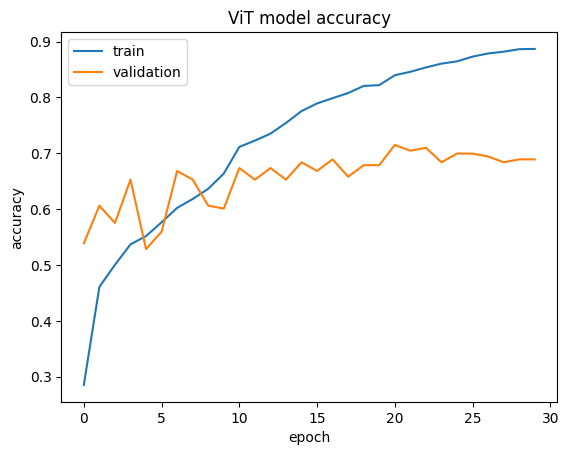

In [ ]:
plot_hist(hist, "ViT")

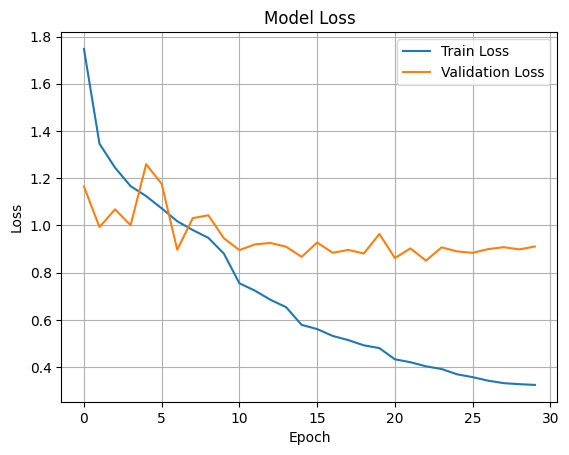

In [ ]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


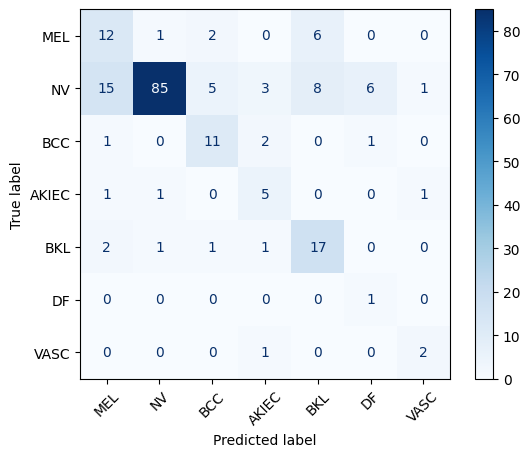

In [ ]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [ ]:
test_loss, *test_metrics = model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 132s 694ms/step - accuracy: 0.6718 - loss: 0.9872
Test Loss: 1.229083776473999
Test Metrics: [0.5965608358383179]


In [ ]:
model_save_name = 'modelCustomViT.keras'
path = f"{base_path}saved_models/{model_save_name}"
model.save(path)

In [ ]:
val_preds = model.predict(df_validate)
val_preds_labels = np.argmax(val_preds, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step


In [ ]:
val_true_labels = []
for _, labels in df_validate:
    val_true_labels.extend(np.argmax(labels.numpy(), axis=1))
val_true_labels = np.array(val_true_labels)

In [ ]:
test_preds = model.predict(df_test)
test_preds_labels = np.argmax(test_preds, axis=1)

test_true_labels = []
for _, labels in df_test:
    test_true_labels.extend(np.argmax(labels.numpy(), axis=1))
test_true_labels = np.array(test_true_labels)

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [ ]:
# Validation scores
print("Validation Metrics:")
print(m.classification_report(val_true_labels, val_preds_labels, target_names=classes))

# Test scores
print("Test Metrics:")
print(m.classification_report(test_true_labels, test_preds_labels, target_names=classes))

Validation Metrics:
              precision    recall  f1-score   support

         MEL       0.39      0.57      0.46        21
          NV       0.97      0.69      0.81       123
         BCC       0.58      0.73      0.65        15
       AKIEC       0.42      0.62      0.50         8
         BKL       0.55      0.77      0.64        22
          DF       0.12      1.00      0.22         1
        VASC       0.50      0.67      0.57         3

    accuracy                           0.69       193
   macro avg       0.50      0.72      0.55       193
weighted avg       0.79      0.69      0.72       193

Test Metrics:
              precision    recall  f1-score   support

         MEL       0.33      0.65      0.44       171
          NV       0.93      0.65      0.76       909
         BCC       0.36      0.35      0.36        93
       AKIEC       0.24      0.49      0.32        43
         BKL       0.39      0.52      0.44       217
          DF       0.38      0.34      0.36 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

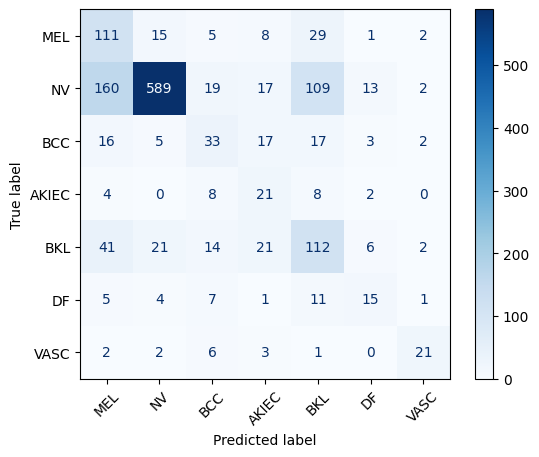

In [ ]:
y_true_test = []
y_pred_test = []

for images, labels in df_test:
    preds = model.predict(images)
    y_true_test.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)